# Fondamenti di Analisi Dati - a.a. 2020/2021

In questo laboratorio tratteremo la regressione logistica.

## 9 Introduzione
Supponiamo di voler studiare la correlazione tra due variabili, di cui una (la variabile dipendente) sia categorica e binaria (ovvero, che può assumere solo i valori $0$ e $1$). Per studiare questo caso, considereremo un esempio riadattato da http://nbviewer.jupyter.org/github/justmarkham/DAT8/blob/master/notebooks/12_logistic_regression.ipynb.

Consideriamo il **Glass Identification Data Set** (https://archive.ics.uci.edu/ml/datasets/glass+identification). Si tratta di un dataset che contiene una serie di misurazioni per diversi campioni di vetro. Carichiamo il csv mediante Pandas:

In [4]:
import pandas as pd
glass = pd.read_csv('glass.csv', index_col='id')
glass.info()
glass.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ri          214 non-null    float64
 1   na          214 non-null    float64
 2   mg          214 non-null    float64
 3   al          214 non-null    float64
 4   si          214 non-null    float64
 5   k           214 non-null    float64
 6   ca          214 non-null    float64
 7   ba          214 non-null    float64
 8   fe          214 non-null    float64
 9   glass_type  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Il dataset contiene $214$ osservazioni e $10$ colonne. I significati delle variabili sono i seguenti:
 * **id**: l'id della riga del DataFrame;
 * **ri**: indice di rifrazione del vetro;
 * **na**: percentuale di sodio;
 * **mg**: percentuale di mercurio;
 * **al**: percentuale di alluminio;
 * **si**: percentuale di silicio;
 * **k**: percentuale di potassio;
 * **ca**: percentuale di calcio;
 * **ba**: percentuale di bario;
 * **fe**: percentuale di ferro;
 * **Tipo di vetro**:
   1. building_windows_float_processed;
   2. building_windows_non_float_processed;
   3. vehicle_windows_float_processed;
   4. vehicle_windows_non_float_processed (questo tipo di vetro non è presente nel dataset!);
   5. containers;
   6. tableware;
   7. headlamps.

I diversi tipi di vetro possono essere raggruppati in due macro-categorie:
 * vetro da finestre (edifici o veicoli): classi 1, 2, 3 (la classe 4 non è presente nel dataset);
 * vetro non da finestre: classi 5, 6, 7;
 
Costruiamo una nuova variabile **window_glass** binaria che mappi le calssi come appena definito. Ciò può essere fatto mediante il metodo `replace`:

In [5]:
glass['window_glass']=glass['glass_type'].replace({1:1,2:1,3:1,5:0,6:0,7:0})
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,window_glass
id,,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1,1


## 9.1 Regressione Logistica Semplice

Supponiamo adesso di voler indagare la correlazione tra la percentuale di alluminio presente nel vetro (variabile `al`) e la variabile dicotomica `window_glass`. In particoalre, vogliamo capire se la variabile `al` influenza l'esito di `window_glass`, ovvero fino a che punto è possibile prevedere il tipo di vetro conoscendo solo la percentuale di alluminio presente. Iniziamo a studiare la correlazione mediante uno scatterplot:

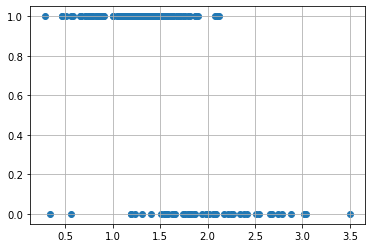

In [6]:
from matplotlib import pyplot as plt
plt.scatter(glass.al,glass.window_glass)
plt.grid()
plt.show()

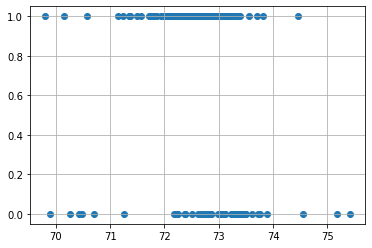

In [8]:
plt.scatter(glass.si,glass.window_glass)
plt.grid()

### Limiti della regressione lineare con variabile dipendente categorica
Proviamo adesso a visualizzare la retta di regressione relativa alle due variabili:

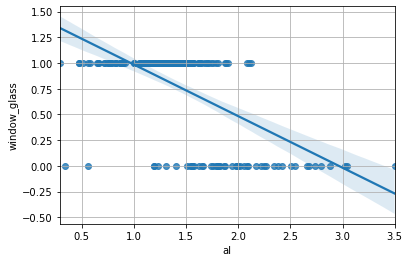

In [10]:
import seaborn as sns
sns.regplot('al','window_glass',glass)
plt.grid()
plt.show()

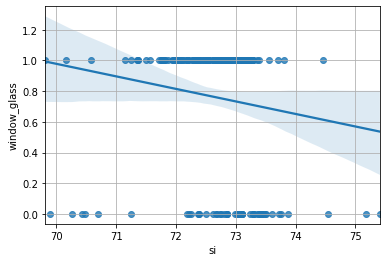

In [12]:
sns.regplot('si','window_glass',glass)
plt.grid()


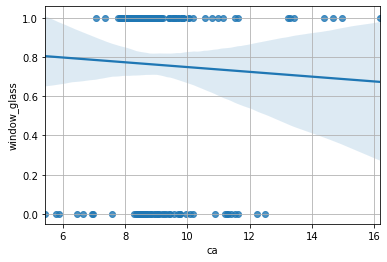

In [13]:
sns.regplot('ca','window_glass',glass)
plt.grid()


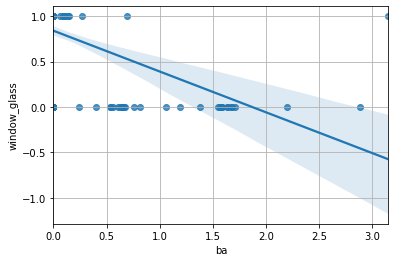

In [14]:
sns.regplot('ba','window_glass',glass)
plt.grid()


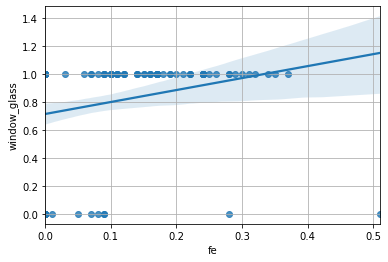

In [15]:
sns.regplot('fe','window_glass',glass)
plt.grid()


Il regressore lineare, in pratica, ci permette di ottenere un numero reale che fornisce indicazioni sul valore più verosimile della variabile dicotomica `window_glass`. Se il valore ottenuto mediante il regressore lineare è maggiore o uguale a $0.5$, ha senso prevedere che **window_glass** sia uguale a **1**, altrimenti ha senso prevedere che **window_glass** sia uguale a **0**. Possiamo dunque ottenere delle predizioni binarie sogliando i valori ottenuti mediante il regressore:

In [16]:
from statsmodels.formula.api import ols
#calcoliamo il regressore lineare
model = ols('window_glass ~ al',glass).fit()
#otteniamo le predizioni
predictions = model.predict(glass)
#arrotondiamo le predizioni al valore più vicino
#ciò corrisponde a sogliare con 0.5
predictions = predictions.round()
#i valori predetti sono adesso binari
predictions.unique()

array([1., 0.])

Plottiamo le predizioni sul grafico di regressione visto prima:

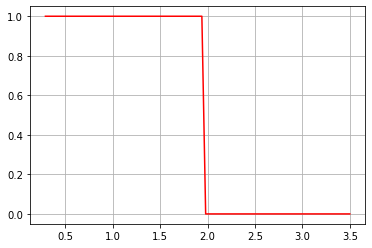

In [24]:
import numpy as np
#ordiniamo i valori di al in ordine crescente
#prima troviamo gli indici che ordinano l'array
idx=np.argsort(glass['al'])
#poi applichiamo lo stesso ordinamento sia ad al che alle predizioni
al = glass['al'].values[idx]
pred = predictions.values[idx]

#infine plottiamo
#sns.regplot('al','window_glass',glass)
plt.plot(al,pred,'r')
plt.grid()
plt.show()

Abbiamo individuato un punto di soglia per `al` (vicino a $2.0$) che permette di distinguere gli elementi appartenenti alle due classi con qualche errore (si pensi ai valori a sinistra di $2.0$ con classe `window_glass` pari a zero).

Benché il regressore lineare trovato possa essere utilizzato per la classificazione, esso ha diversi limiti:
 * Non è chiaro come interpretare i valori ottenuti dal regressore. Si noti che, dato che essi possono essere inferiori a $0$ o superiori a $1$, essi non possono essere interpretati come probabilità;
 * Il metodo non è molto robusto agli outliers. Si immagini che il nostro campione contenga molti punti di classe  `window_glass` pari a $0$ e valori di `al` molto alti (es. $300$). La retta di regressione trovata in questo caso sarebbe molto più orizzontale e molti degli elementi con valori bassi di `al` (es. $2.5$) verrebbero assegnati alla classe `window_glass=0`;
 * Il metodo non cattura l'incertezza con la quale possiamo prevedere le classi alle quali appartengono gli elementi. Si considerino ad esempio i punti compresi tra `al=1.5` e `al=2.0`.

### Regressione Logistica
Per risolvere i problemi discussi sopra, il problema di regressione viene ridefinito come segue:

\begin{equation}
logit(p)=\beta_0 + \beta_1 x
\end{equation}

dove $p$ è la **probabilità che la variabile dipendente assuma valore 1** e:

\begin{equation}
logit(p)=ln(\frac{p}{1-p})
\end{equation}

La funzione logit è il logaritmo naturale dell'**odd**, ovvero del rapporto $\frac{p}{1-p}$.

Una volta trovati i parametri $\beta_0$ e $\beta_1$, la stima della probabilità avviene come segue:

\begin{equation}
p = \frac{e^{\beta_0 + \beta_1 x}}{1+e^{\beta_0+\beta_1 x}}
\end{equation}

Possiamo calcolare un **regressore logistico** come segue:

In [7]:
from statsmodels.formula.api import logit

model = logit('window_glass ~ al', glass).fit()

Optimization terminated successfully.
         Current function value: 0.354364
         Iterations 7


Vedremo come analizzare il regressore e interpretare i coefficienti trovati in seguito.

Possiamo ottenere le probabilità predette per i valori delle variabili indipendenti come segue:

In [8]:
probs = model.predict(glass)
probs.head()

id
1    0.957513
2    0.883730
3    0.781728
4    0.910590
5    0.926211
dtype: float64

Si noti che i valori ottenuti sono adesso compresi tra $0$ e $1$ e dunque interpretabili come probabilità:

In [9]:
probs.min(), probs.max()

(0.0009889852519933465, 0.9985007304335234)

Considereremo un elemento come appartenente alla classe `window_glass=1` se la sua probabilità predetta è superiore a $0.5$.

Plottiamo le predizioni come fatto in precedenza:

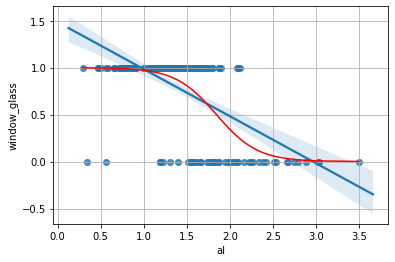

In [10]:
#riordiniamo le probabilità utilizzando 
#gli indici trovati prima
p = probs.values[idx]

sns.regplot('al','window_glass',glass)
plt.plot(al,p,'r')
plt.grid()
plt.show()

Le probabilità ottenute mostrano adesso "dove" il modello è più incerto e permettono di **prevedere la probabilità che un dato elemento sia di classe `window_glass=1`**. Possiamo ottenere un plot di regressione logistica con seaborn come segue:

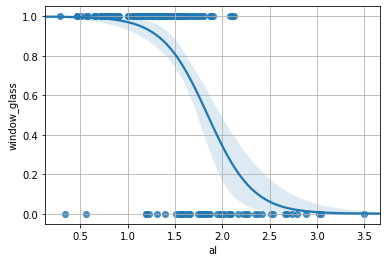

In [11]:
sns.regplot(glass['al'],glass['window_glass'],logistic=True)
plt.grid()
plt.show()

### Analisi del regressore logistico
Visualizziamo il summary del regressore logistico calcolato in precedenza:

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           window_glass   No. Observations:                  214
Model:                          Logit   Df Residuals:                      212
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.3547
Time:                        10:43:56   Log-Likelihood:                -75.834
converged:                       True   LL-Null:                       -117.51
Covariance Type:            nonrobust   LLR p-value:                 6.835e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7136      1.078      7.158      0.000       5.602       9.826
al            -4.1804      0.660     -6.338      0.000      -5.473      -2.888
==============================================================================
"""

#### Significatività
Il summary presenta diversi elementi. Analizziamone i più importanti:
 * Pseudo R-squared: va interpretato come l'R-Squared nel caso della regressione lineare. Ci dice quanto il modello "spiega" bene i dati;
 * LLR p-value: è il p-value calcolato da un "Likelihood-ratio test" (Rapporto di verosimiglianza). Se il valore del p-value è al di sotto di una soglia critica, (es. $0.05$), il regressore logistico è statisticamente rilevante;
 * P-value dei coefficienti ($P>|z|$): vanno interpretati come nel caso della regressione lineare. P-value piccoli indicano che le variabili coinvolte contribuiscono significativamente alla regressione.
 
Nel caso specifico del regressore allenato, possiamo dire che:
 * Il regressore logistico spiega parte della relazione tra le variabili (pseudo $R^2$ pari a circa $0.35$);
 * Il regressore logistico è statisticamente rilevante (p-value al di sotto di $0.05$);
 * I coefficienti sono tutti statisticamente rilevanti (p-value bassi);

#### Interpretazione dei valori dei coefficienti
Vediamo adesso come interpretare i coefficienti di un regressore logistico. Ricordiamo che il modello di regressione (nel caso della regressione semplice) è il seguente:

\begin{equation}
\ln(\frac{p}{1-p})=\beta_0 + \beta_1 x
\end{equation}

Applicando quanto conosciamo riguardo ai regressori lineari, possiamo dire che, per $x=0$, $\ln(\frac{p}{1-p})=\beta_0$.<br>
Se vogliamo avere un quadro più chiaro, applichiamo la funzione <em>exp</em> all'equazione in modo da avere, per $x=0$, $\frac{p}{1-p}=e^{\beta_0}$.<br>
Ricordiamoci che $\frac{p}{1-p}$ è l'odds che la variabile dipendente sia pari a $1$ e, in quanto tale, ha una interpretazione chiara. Ad esempio, se l'odds di un evento è pari a $3$, allora è $3$ volte più probabile che esso si verifichi piuttosto che non si verifichi. Possiamo dunque dire che, **per $x=0$, è $e^{\beta_0}$ volte più probabile che la variabile dipendente sia pari a $1$**.

Come possiamo interpretare i valori dei coefficienti? Cerchiamo di capire che effetto ha sugli odds l'incremento di una unità della variabile $x$. Secondo il nostro regressore:

\begin{equation}
\ln odds(x) = \beta_0 + \beta_1 x
\end{equation}

Possiamo dunque scrivere:
\begin{equation}
\ln odds(x+1) - \ln odds(x) = \beta_0 + \beta_1 (x+1) - \beta_0 - \beta_1 x = \beta_1 (x+1) - \beta_1 x = \beta_1
\end{equation}

Esponenziando ambi i membri otteniamo:
\begin{equation}
e^{\ln odds(x+1) - \ln odds(x)} = e^{\beta_1} \Rightarrow \frac{e^{\ln odds(x+1)}}{e^{\ln odds(x)}} = e^{\beta_1} \Rightarrow \frac{odds(x+1)}{odds(x)} = e^{\beta_1} \Rightarrow odds(x+1) = e^{\beta_1}odds(x)
\end{equation}

Possiamo dunque dire che **l'incremento di una unità della variabile $x$ corrisponde a un incremento moltiplicativo dell'odds di $e^{\beta_1}$**.

L'analisi si estende al caso della regressione multivariata come visto nel caso della regressione lineare.

#### Esempio di analisi dei coefficienti di un regressore logistico
Analizziamo i coefficienti del regressore logistico calcolato prima. Visualizziamo nuovamente il summary:

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           window_glass   No. Observations:                  214
Model:                          Logit   Df Residuals:                      212
Method:                           MLE   Df Model:                            1
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.3547
Time:                        10:43:56   Log-Likelihood:                -75.834
converged:                       True   LL-Null:                       -117.51
Covariance Type:            nonrobust   LLR p-value:                 6.835e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7136      1.078      7.158      0.000       5.602       9.826
al            -4.1804      0.660     -6.338      0.000      -5.473      -2.888
==============================================================================
"""

Calcoliamo l'esponenziale dei valori dei coefficienti:

In [14]:
np.exp(model.params)

Intercept    2238.577657
al              0.015292
dtype: float64

Possiamo dire che:
 * Per $al=0$, l'odds che il vetro sia da finestra (`window_glass=1`) è pari a circa $2238$. E' dunque $2238$ volte più probabile che il vetro sia da finestra;
 * L'incremento di una unità del valore della variabile `al` corrisponde a un incremento moltiplicativo di $0.015$. Dato che il numero è minore di 1, ciò corrisponde a un decremento moltiplicativo pari a $1-0.015=0.985$. Possiamo dire dunque che l'incremento di una unità del valore di `al` corrisponde a un decremento del $98.5\%$ dell'odds.

## 9.2 Regressione Logistica Multipla

E' possibile calcolare un regressore logistico a partire da più variabili indipendenti semplicemente rivedendo il modello come:

\begin{equation}
logit(p)=\beta_0 + \beta_1 x_1 + \ldots + \beta_n x_n
\end{equation}

Proviamo a calcolare il modello scegliendo come variabili indipendenti **na** e **si** e mantenendo **window_glass** come variabile dipendente. Possiamo visualizzare lo scatterplot con le classi evidenziate utilizzando searborn:

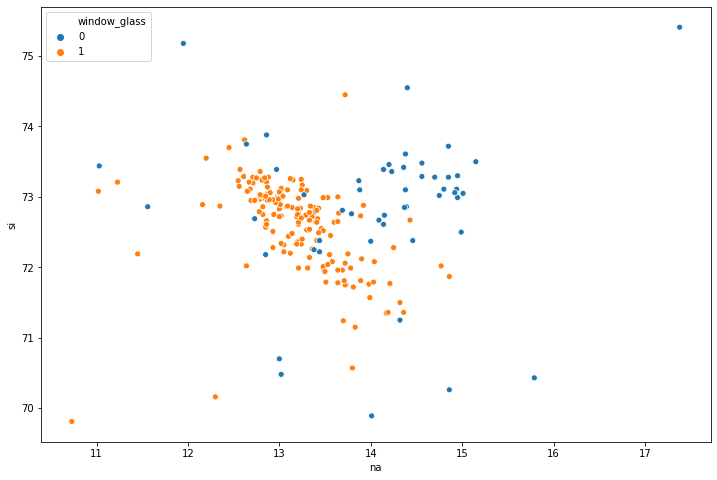

In [15]:
plt.figure(figsize=(12,8))
sns.scatterplot('na','si',data=glass, hue='window_glass')
plt.show()

Calcoliamo il regressore logistico multivariato:

In [16]:
model = logit('window_glass ~ na + si',glass).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.409695
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           window_glass   No. Observations:                  214
Model:                          Logit   Df Residuals:                      211
Method:                           MLE   Df Model:                            2
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.2539
Time:                        10:43:57   Log-Likelihood:                -87.675
converged:                       True   LL-Null:                       -117.51
Covariance Type:            nonrobust   LLR p-value:                 1.098e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.9716     22.944      4.008      0.000      47.002     136.941
na            -1.8780      0.306     -6.143      0.000      -2.477      -1.279
si            -0.8988      0.292     -3.075      0.002      -1.472      -0.326
==============================================================================
"""

Analizziamo in breve il risultato della regressione logistica:
 * Il modello spiega parte della relazione tra le variabili indipendenti e la variabile dipendente ($R^2=0.2539$);
 * Il regressore si distingue in maniera rilevante dal regressore nullo (p-value sotto la soglia critica $0.05$);
 * I parametri del regressore sono tutti statisticamente rilevanti (p-value tutti sotto la soglia $0.05$);
Calcoliamo l'esponenziale dei parametri:

In [17]:
np.exp(model.params)

Intercept    8.764972e+39
na           1.528937e-01
si           4.070460e-01
dtype: float64

 * Se `na=0` e `si=0`, il vetro è da finestra in maniera quasi certa;
 * Se la variabile `si=0`, l'incremento di una unità della variabile `na` causa un decremento dell'odds di circa il $98,48\%$;
 * Se la variabile `na=0`, l'incremento di una unità della variabile `si` causa un decremento dell'odds pari a circa il $96\%$.

### Interpretazione geometrica dei coefficienti
I coefficienti trovati possono interpretati in maniera geometrica. Il modello di regressione che abbiamo utilizzato nel caso bivariato è assimilabile al seguente:

\begin{equation}
\ln\frac{p}{1-p} = \beta_0 + \beta_1 x_1 + \beta_2 x_2
\end{equation}

Cerchiamo di capire se esistono dei vaori "soglia" di $x_1$ e $x_2$ oltre i quali il modello classifichi i dati come appartenenti alla classe "window_glass". Per farlo, analizziamo per quali valori di $x_1$ e $x_2$ il modello ha massima incertezza. Ciò avviene quando l'odds è pari a $1$ e la probabilità predetta è pari a $p=0.5$. In questo caso possiamo scrivere:

\begin{equation}
\ln 1 = 0 = \beta_0 + \beta_1 x_1 + \beta_2 x_2
\end{equation}

da cui:

\begin{equation}
x_2 = - \frac{\beta_0}{\beta_2} - \frac{\beta_1}{\beta2} x_1
\end{equation}

che è l'equazione di una retta $y=mx+q$ di coefficiente angolare $m=-\frac{\beta_1}{\beta_2}$ e intercetta $q=-\frac{\beta_0}{\beta_2}$.

Questa retta rappresenta il luogo dei punti per i quali il modello ha incertezza massima, che è detto anche **decision boundary** (confine di decisione) del modello. Vediamo di visualizzarlo sul plot precedente:

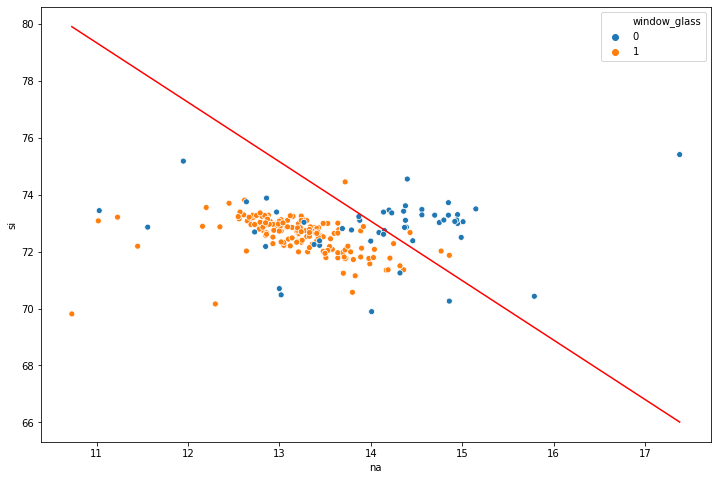

In [18]:
b0 = model.params.Intercept
b1 = model.params.na
b2 = model.params.si

m = -b1/b2
q= - b0/b2

x = np.linspace(np.min(glass.na),np.max(glass.na),2)
y = m*x+q

plt.figure(figsize=(12,8))
sns.scatterplot('na','si',data=glass, hue='window_glass')
plt.plot(x,y,'r')
plt.show()

Il decision boundary trovato **divide lo spazio in due parti**: da una parte si trovano i punti che secondo il modello appartengono alla classe "window_glass", mentre dall'altra parte si trovano i punti associati all'altra classe.

## 9.3 Esempio di regressione logistica con più di due variabili indipendenti
Vediamo un esempio di regressione logistica con più di due variabili indipendenti. Utilizzeremo il dataset di R `biopsy`. Possiamo caricarlo mediante `statsmodels`:

In [19]:
from statsmodels.datasets import get_rdataset
biopsy = get_rdataset('biopsy',package='MASS')
print(biopsy.__doc__)

C:\Users\visig\Anaconda3\lib\site-packages\statsmodels\datasets\utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


====== ===============
biopsy R Documentation
====== ===============

Biopsy Data on Breast Cancer Patients
-------------------------------------

Description
~~~~~~~~~~~

This breast cancer database was obtained from the University of
Wisconsin Hospitals, Madison from Dr. William H. Wolberg. He assessed
biopsies of breast tumours for 699 patients up to 15 July 1992; each of
nine attributes has been scored on a scale of 1 to 10, and the outcome
is also known. There are 699 rows and 11 columns.

Usage
~~~~~

::

   biopsy

Format
~~~~~~

This data frame contains the following columns:

``ID``
   sample code number (not unique).

``V1``
   clump thickness.

``V2``
   uniformity of cell size.

``V3``
   uniformity of cell shape.

``V4``
   marginal adhesion.

``V5``
   single epithelial cell size.

``V6``
   bare nuclei (16 values are missing).

``V7``
   bland chromatin.

``V8``
   normal nucleoli.

``V9``
   mitoses.

``class``
   ``"benign"`` or ``"malignant"``.

Source
~~~~~~

P. M. M

Il dataset contiene $699$ osservazioni e $11$ colonne. Ogni osservazioni contiene misurazioni di $9$ grandezze relative a campioni di tessuto che possono essere tumori "benigni" o "maligni". Iniziamo manipolando un po' i dati. Visualizziamo i valori della variabile `class`:

In [20]:
biopsy.data['class'].unique()

array(['benign', 'malignant'], dtype=object)

Per calcolare il modello di regressione logistica mediante statsmodels è necessario convertire questi valori in interi ($0$ o $1$). Inoltre, conviene evitare di chiamare la colonna `class` in quanto questa è una parola riservata per statsmodels. Costruiamo una nuova colonna `cl` che contiene i valori di `class` modificati:

In [21]:
biopsy.data['cl'] = biopsy.data['class'].replace({'benign':0, 'malignant':1})

Procediamo a calcolare il regressore logistico considerando tutte le variabili:

In [22]:
model = logit('cl ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9',biopsy.data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.075321
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     cl   No. Observations:                  683
Model:                          Logit   Df Residuals:                      673
Method:                           MLE   Df Model:                            9
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.8837
Time:                        10:43:59   Log-Likelihood:                -51.444
converged:                       True   LL-Null:                       -442.18
Covariance Type:            nonrobust   LLR p-value:                2.077e-162
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1039      1.175     -8.600      0.000     -12.407      -7.801
V1             0.5350      0.142      3.767      0.000       0.257       0.813
V2            -0.0063      0.209     -0.030      0.976      -0.416       0.404
V3             0.3227      0.231      1.399      0.162      -0.129       0.775
V4             0.3306      0.123      2.678      0.007       0.089       0.573
V5             0.0966      0.157      0.617      0.537      -0.210       0.404
V6             0.3830      0.094      4.082      0.000       0.199       0.567
V7             0.4472      0.171      2.609      0.009       0.111       0.783
V8             0.2130      0.113      1.887      0.059      -0.008       0.434
V9             0.5348      0.329      1.627      0.104      -0.110       1.179
==============================================================================
"""

Il regressore logistico spiega bene la relazione tra le variabili ($R^2$ alto) ed è significativo (p-value quasi nullo). Alcuni coefficienti hanno un p-value alto. Iniziamo eliminando la variabile `V2`, che ha il p-value più alto:

In [23]:
model = logit('cl ~ V1 + V3 + V4 + V5 + V6 + V7 + V8 + V9',biopsy.data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.075321
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     cl   No. Observations:                  683
Model:                          Logit   Df Residuals:                      674
Method:                           MLE   Df Model:                            8
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.8837
Time:                        10:43:59   Log-Likelihood:                -51.445
converged:                       True   LL-Null:                       -442.18
Covariance Type:            nonrobust   LLR p-value:                2.036e-163
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.0976      1.155     -8.739      0.000     -12.362      -7.833
V1             0.5346      0.141      3.784      0.000       0.258       0.811
V3             0.3182      0.174      1.826      0.068      -0.023       0.660
V4             0.3299      0.121      2.723      0.006       0.092       0.567
V5             0.0961      0.156      0.618      0.537      -0.209       0.401
V6             0.3831      0.094      4.082      0.000       0.199       0.567
V7             0.4465      0.170      2.628      0.009       0.114       0.779
V8             0.2125      0.112      1.902      0.057      -0.006       0.432
V9             0.5341      0.328      1.630      0.103      -0.108       1.176
==============================================================================
"""

Procediamo rimuovendo `V5`, che ha p-value pari a $0.537$:

In [24]:
model = logit('cl ~ V1 + V3 + V4 + V6 + V7 + V8 + V9',biopsy.data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.075598
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     cl   No. Observations:                  683
Model:                          Logit   Df Residuals:                      675
Method:                           MLE   Df Model:                            7
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.8832
Time:                        10:44:00   Log-Likelihood:                -51.633
converged:                       True   LL-Null:                       -442.18
Covariance Type:            nonrobust   LLR p-value:                2.240e-164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.9828      1.126     -8.865      0.000     -12.190      -7.776
V1             0.5340      0.141      3.793      0.000       0.258       0.810
V3             0.3453      0.172      2.012      0.044       0.009       0.682
V4             0.3425      0.119      2.873      0.004       0.109       0.576
V6             0.3883      0.094      4.150      0.000       0.205       0.572
V7             0.4619      0.168      2.746      0.006       0.132       0.792
V8             0.2261      0.111      2.037      0.042       0.009       0.444
V9             0.5312      0.324      1.637      0.102      -0.105       1.167
==============================================================================
"""

Rimuoviamo `V9`, che ha p-value superiore a $0.05$:

In [25]:
model = logit('cl ~ V1 + V3 + V4 + V6 + V7 + V8',biopsy.data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.078436
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     cl   No. Observations:                  683
Model:                          Logit   Df Residuals:                      676
Method:                           MLE   Df Model:                            6
Date:                Thu, 05 Nov 2020   Pseudo R-squ.:                  0.8788
Time:                        10:44:00   Log-Likelihood:                -53.572
converged:                       True   LL-Null:                       -442.18
Covariance Type:            nonrobust   LLR p-value:                1.294e-164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.7671      1.085     -9.001      0.000     -11.894      -7.640
V1             0.6225      0.137      4.540      0.000       0.354       0.891
V3             0.3495      0.165      2.118      0.034       0.026       0.673
V4             0.3375      0.116      2.920      0.004       0.111       0.564
V6             0.3786      0.094      4.035      0.000       0.195       0.562
V7             0.4713      0.166      2.837      0.005       0.146       0.797
V8             0.2432      0.109      2.240      0.025       0.030       0.456
==============================================================================
"""

Tutti i coefficienti hanno adesso un p-value accettabile. Proseguiamo all'analisi dei coefficienti. Calcoliamo gli esponenziali:

In [26]:
np.exp(model.params)

Intercept    0.000057
V1           1.863641
V3           1.418374
V4           1.401487
V6           1.460166
V7           1.602133
V8           1.275287
dtype: float64

 * Il valore dell'esponenziale dell'intercetta quasi nullo indica che, quando tutte le variabili assumono valori nulli, l'odds è molto basso. Ciò indica che $p$ è basso, mentre $1-p$ è molto alto. La probabilità di avere un tumore maligno è quindi molto bassa se tutte le variabili assumono valori nulli;
 * L'incremento di una unità del valore di `V1` corrisponde all'incremento di circa l'$86\%$ dell'odds, il che rende la possibilità di un tumore maligno più alta;
 * L'incremento di una unità del valore di `V3` corrisponde all'incremento di circa il $41\%$ dell'odds;
 * L'incremento di una unità del valore di `V4` corrisponde all'incremento di circa il $40\%$ dell'odds;
 * L'incremento di una unità del valore di `V6` corrisponde all'incremento di circa il $46\%$ dell'odds;
 * L'incremento di una unità del valore di `V7` corrisponde all'incremento di circa il $60\%$ dell'odds;
 * L'incremento di una unità del valore di `V8` corrisponde all'incremento di circa il $27\%$ dell'odds;
 
L'incremento delle variabili, in genere, causa un incremento dell'odds. Pertanto ci aspettiamo che i valori delle variabili siano piccoli in presenza di tumori benigni.

## - Regressione Logistica - FINE 